# Определение цен на авто



## Helper

In [1]:
%%writefile helper.py

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import eli5

def parse_price(val):
    return float(val.replace(" ", "").replace(",", "."))

def get_df(df_train, df_test):
    df_train = df_train[ df_train.index != 106447 ].reset_index(drop=True)
    df = pd.concat([df_train, df_test])
 
    params = df["offer_params"].apply(pd.Series)
    params = params.fillna(-1)

    ru_params = ["Безаварийный", "Количество мест", "Страна происхождения",
       "Объем", "Тип топлива", "Коробка передач",
       "Кредит", "Первый владелец", "Предложение от",
       "Количество дверей", "Пробег", "Мощность", "Металлик", "Тип", "Цвет",
       "Модель автомобиля", "Состояние", "Категория", "Обслуживание в сервисном центре", "Привод",
       "Лизинг", "Год выпуска", "Марка автомобиля", "Счет-фактура по НДС",
       "Первая регистрация", "Зарегистрировано в Польше", "Маржа НДС",
       "Версия", "VIN", "Перламутр", "Поврежденный", "Код двигателя",
       "Сажевый фильтр", "Выбросы CO2", "Ежемесячный платеж",
       "Количество оставшихся платежей", "Первоначальный платеж", "Сумма погашения",
       "Акрил (неметаллический)", "Тюнинг", "Правый руль (английский)",
       "Допуск грузовика"]


    dict_params = {pl:ru for pl,ru in zip(params.columns, ru_params)}
    params.rename(columns=dict_params, inplace=True)

    df = pd.concat([df, params], axis=1)
    print(df.shape)

    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]
            
    return df

def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error", show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    df_test = df[ df["price_value"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price_value"]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X_train, y_train)
        print(result)
        return eli5.show_weights(model, feature_names=feats)
    
    return result

def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

Overwriting helper.py


## Импортируем библиотеки

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from tqdm import tqdm
import helper as h


import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import eli5
import re

## Загружаем и объединяем

In [3]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train["price_value"] = df_train['price_value'].map(h.parse_price)

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [4]:
# включаем опцию отображения всех столбцов
pd.options.display.max_columns = None

In [5]:
df_train.head()

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
7,7,"Cena Brutto, Faktura VAT",63900.000,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",TRANS-AUTO SP. Z O.O. DEALER MARKI ...,Dealer,"ŁUKASIEWICZA 1 - 19-300 Ełk, ełcki, Warmińsko-...","[Osobowe, Citroën, C4 Cactus]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
10,10,Cena Brutto,41900.000,PLN,"[ABS, ASR (kontrola trakcji), Elektryczne szyb...",DECAR - RENAULT i DACIA,Dealer,"MODLIŃSKA 154 B - 03-170 Warszawa, Mazowieckie...","[Osobowe, Nissan, Juke]","{'Kolor': 'Czarny', 'Model pojazdu': 'Juke', '..."
11,11,"Cena Brutto, Do negocjacji",17950.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",SKUP SPRZEDAŻ ZAMIANA RATY,Dealer,"Ruchocinek 63c - 62-230 Witkowo, gnieźnieński,...","[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
14,14,"Cena Brutto, Do negocjacji",38000.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Chróścice, opolski, Opolskie","[Osobowe, Audi, A4, Audi A4 B8 (2007-2015)]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni..."
16,16,Cena Brutto,21900.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Trzeboszowice, nyski, Opolskie","[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."


In [6]:
df_test.head()

,id,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
0,0,"[ABS, Czujnik deszczu, Elektryczne szyby przed...",Autopunkt.pl Rzeszów,Dealer,"Podkarpacka 6b - 35-082 Rzeszów, Podkarpackie ...","[Osobowe, Škoda, Superb, Škoda Superb II (2008-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
1,1,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Prudnik, prudnicki, Opolskie","[Osobowe, Audi, A4, Audi A4 B8 (2007-2015)]","{'Pojemność skokowa': '1 968 cm3', 'Model poja..."
2,2,"[ABS, Elektrycznie ustawiane lusterka, Immobil...",AUTO CENTRUM,Dealer,44-144 GLIWICE / NIEBOROWICE UL. MYSIA GÓRA 18...,"[Osobowe, Ford, Focus, Ford Focus Mk3 (2010-)]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Cz..."
3,3,"[ABS, Elektryczne szyby przednie, Poduszka pow...",AUTO HANDEL Żółkowscy,Dealer,"siedlce - 08-110 Siedlce, Mazowieckie (Polska)","[Osobowe, Mercedes-Benz, CLA, CLA 180]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Po..."
4,4,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Swarzędz, poznański, Wielkopolskie","[Osobowe, Citroën, Berlingo, Citroën Berlingo ...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."


## `df` - объединяем данные
В `helper` есть функция `get_df`. Там выполняется объединение таблиц данных (тренировочной и тестовой для анализа единого массива данных), удаление аутлайера (106447), парсинг json во всех строках столбца offer_params и добавление на его базе новых столбцов категорий, перевод на русский названий категорий.

In [7]:
df = h.get_df(df_train, df_test)

(160257, 86)


In [10]:
df.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Безаварийный,Количество мест,Страна происхождения,Объем,Тип топлива,Коробка передач,Кредит,Первый владелец,Предложение от,Количество дверей,Пробег,Мощность,Металлик,Тип,Цвет,Модель автомобиля,Состояние,Категория,Обслуживание в сервисном центре,Привод,Лизинг,Год выпуска,Марка автомобиля,Счет-фактура по НДС,Первая регистрация,Зарегистрировано в Польше,Маржа НДС,Версия,VIN,Перламутр,Поврежденный,Код двигателя,Сажевый фильтр,Выбросы CO2,Ежемесячный платеж,Количество оставшихся платежей,Первоначальный платеж,Сумма погашения,Акрил (неметаллический),Тюнинг,Правый руль (английский),Допуск грузовика,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Безаварийный_cat,Количество мест_cat,Страна происхождения_cat,Объем_cat,Тип топлива_cat,Коробка передач_cat,Кредит_cat,Первый владелец_cat,Предложение от_cat,Количество дверей_cat,Пробег_cat,Мощность_cat,Металлик_cat,Тип_cat,Цвет_cat,Модель автомобиля_cat,Состояние_cat,Категория_cat,Обслуживание в сервисном центре_cat,Привод_cat,Лизинг_cat,Год выпуска_cat,Марка автомобиля_cat,Счет-фактура по НДС_cat,Первая регистрация_cat,Зарегистрировано в Польше_cat,Маржа НДС_cat,Версия_cat,VIN_cat,Перламутр_cat,Поврежденный_cat,Код двигателя_cat,Сажевый фильтр_cat,Выбросы CO2_cat,Ежемесячный платеж_cat,Количество оставшихся платежей_cat,Первоначальный платеж_cat,Сумма погашения_cat,Акрил (неметаллический)_cat,Тюнинг_cat,Правый руль (английский)_cat,Допуск грузовика_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat
73443,146957,Cena Brutto,16900.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Mińsk Mazowiecki, miński, Mazowieckie","[Osobowe, Toyota, Yaris, Toyota Yaris II (2005...","{'Pojemność skokowa': '1 300 cm3', 'Model poja...",-1,5,-1,1 300 cm3,Benzyna,"Półautomatyczna (ASG, Tiptronic)",-1,-1,Osoby prywatnej,5,57 000 km,86 KM,Tak,Auta miejskie,Inny kolor,Yaris,Używane,Osobowe,-1,Na przednie koła,-1,2008,Toyota,-1,-1,-1,Tak,II (2005-2011),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,39,0,2,1,1,1,0,556,54,0,4,4,132,0,0,1,0,1,2,16,1,2,1,1,269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25432,50722,Cena Brutto,27999.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Warszawa, Mazowieckie, Włochy","[Osobowe, Škoda, Superb, Škoda Superb I (2001-...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",Tak,5,Niemcy,2 771 cm3,Benzyna+LPG,Automatyczna hydrauliczna (klasyczna),-1,-1,Osoby prywatnej,4,214 000 km,194 KM,Tak,Sedan,Złoty,Superb,Używane,Osobowe,Tak,Na przednie koła,-1,2007,Škoda,-1,30 maj 2007,Tak,-1,I (2001-2008),TMBBT63U179019289,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,160,2,3,1,1,1,2,287,14,0,3,12,7,0,0,0,0,1,6,6,1,1956,0,0,7,5518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Категориальные признаки

In [8]:
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['Безаварийный_cat',
 'Количество мест_cat',
 'Страна происхождения_cat',
 'Объем_cat',
 'Тип топлива_cat',
 'Коробка передач_cat',
 'Кредит_cat',
 'Первый владелец_cat',
 'Предложение от_cat',
 'Количество дверей_cat',
 'Пробег_cat',
 'Мощность_cat',
 'Металлик_cat',
 'Тип_cat',
 'Цвет_cat',
 'Модель автомобиля_cat',
 'Состояние_cat',
 'Категория_cat',
 'Обслуживание в сервисном центре_cat',
 'Привод_cat',
 'Лизинг_cat',
 'Год выпуска_cat',
 'Марка автомобиля_cat',
 'Счет-фактура по НДС_cat',
 'Первая регистрация_cat',
 'Зарегистрировано в Польше_cat',
 'Маржа НДС_cat',
 'Версия_cat',
 'VIN_cat',
 'Перламутр_cat',
 'Поврежденный_cat',
 'Код двигателя_cat',
 'Сажевый фильтр_cat',
 'Выбросы CO2_cat',
 'Ежемесячный платеж_cat',
 'Количество оставшихся платежей_cat',
 'Первоначальный платеж_cat',
 'Сумма погашения_cat',
 'Акрил (неметаллический)_cat',
 'Тюнинг_cat',
 'Правый руль (английский)_cat',
 'Допуск грузовика_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_ca

## Тренируем модель
Применим функцию `h.check_model`

In [11]:
h.check_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(-12350.06346314468, 343.56887468969046)


Weight,Feature
0.1729,Привод_cat
0.1483,Состояние_cat
0.0823,Счет-фактура по НДС_cat
0.0759,Год выпуска_cat
0.0466,Коробка передач_cat
0.0454,Предложение от_cat
0.0360,Мощность_cat
0.0351,Марка автомобиля_cat
0.0313,Кредит_cat
0.0285,Объем_cat


Теперь поменяем способ тренировки модели.

Возможно, уже становится более понятно, что распределение данных влияет на среднее значение. Именно поэтому мы удалили одну из машин-аутлайера.

Для того, чтобы немного "выровнять" распределение, можем воспользоваться логарифмом. 

### Оригинальное распределение цены

<AxesSubplot:>

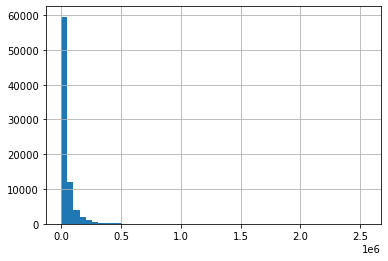

In [12]:
df[ df["price_value"].notnull() ]["price_value"].hist(bins=50)

## Распределение - оптимизированное (при использование логарифма)

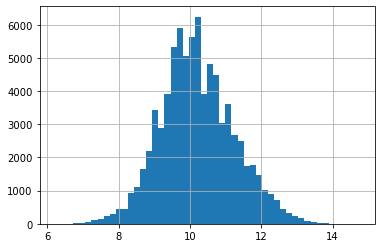

In [13]:
np.log(df[ df["price_value"].notnull() ]["price_value"]).hist(bins=50);

Видно, что во втором случае, данные более симметричные. А зачем нам симметрия? Разные могут быть причины, одна из них - это то, что среднее значение работает более качественно. Давай проверим.

In [14]:
{
    "mean": df["price_value"].mean(),
    "median": df["price_value"].median() ,
    "log_mean": np.exp( np.log(df["price_value"]).mean() )
}


{'mean': 48347.8537105631, 'median': 25600.0, 'log_mean': 27276.9159216702}

В первом случае оно говорит, что в среднем машина стоит около 48к злотых. Но ведь половина машин стоит 25,6k (медиана). Если же мы найдем среднее по логарифму, то получается цена 27,2k (близко к медиане).

Так как мы используем деревья решений (xgboost их тоже из использует внутри), где среднее значение играет критическую роль, стоит немного помочь модели.

## Check Log Model
Переделаем функцию проверки и пропустим цену через логарифм `log`.

In [15]:
def check_log_model(df, feats, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

In [16]:
check_log_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:16,  4.06s/it]


(11044.362886825718, 45.982737402831276)


Weight,Feature
0.3143,Счет-фактура по НДС_cat
0.0886,Состояние_cat
0.0731,Год выпуска_cat
0.0702,Кредит_cat
0.0676,Коробка передач_cat
0.0507,Привод_cat
0.0490,Обслуживание в сервисном центре_cat
0.0341,Тип_cat
0.0266,Поврежденный_cat
0.0236,Безаварийный_cat


Стало лучше **12,4k vs 11k**. Добавим признак - `Год выпуска`.

In [17]:
df["year_production"] = df["Год выпуска"].astype(int)
feats = ["year_production"] + cat_feats

check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:16,  4.12s/it]


(9932.263072210135, 130.3836248354623)


Weight,Feature
0.3857,year_production
0.1660,Привод_cat
0.0426,Коробка передач_cat
0.0414,Поврежденный_cat
0.0341,Обслуживание в сервисном центре_cat
0.0253,Безаварийный_cat
0.0243,Тип_cat
0.0218,Счет-фактура по НДС_cat
0.0209,Правый руль (английский)_cat
0.0207,Перламутр_cat


Уже ушли от ошибки в **10k**.

Еще одно наблюдение. Часть данных у нас еще содержится в столбцах с английским наименованием. Вот например -  `Year`. Как эти два признака взаимосвязаны (`Year` vs `year_production`)?.

In [18]:
pd.crosstab(df.year_production, df.Year)

Year,-1,1989,1992,1995,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
year_production,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0,1,1,2,2,1,1,2,2,4,2,7,5,7,12,9,4,12,6,6,7,8,4,4,15,4
1929,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1930,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1931,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1932,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,8682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015,6424,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016,7153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
df[ df.year_production == -1 ][["year_production", "Year"]]

,year_production,Year
314,-1,2006
466,-1,2012
601,-1,2007
3214,-1,2014
3543,-1,2007
...,...,...
143347,-1,2005
148522,-1,2017
149537,-1,2008
155387,-1,2017


Для `year_production=-1` (т.е. отсутствие данных), у нас есть данные в `Year`. Давай эти признаки объединим в один признак.

In [20]:
df["year_production_ext"] = df.apply(
    lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1
)

Проверим, сколько у нас осталось значений "-1" после объединения двух  признаков.

In [21]:
df[ df["year_production_ext"] == -1 ].shape

(0, 164)

Хорошо - пропусков нет! И сразу проверим, стала ли модель лучше работать.

In [22]:
feats = ["year_production_ext"] + cat_feats
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:16,  4.14s/it]


(9910.945061719669, 118.57846004003517)


Weight,Feature
0.4031,year_production_ext
0.1644,Привод_cat
0.0441,Обслуживание в сервисном центре_cat
0.0409,Коробка передач_cat
0.0347,Поврежденный_cat
0.0343,Тип_cat
0.0256,Счет-фактура по НДС_cat
0.0227,Правый руль (английский)_cat
0.0224,Безаварийный_cat
0.0158,Состояние_cat


Результат стал лучше именно благодаря преобразованию цены. Модель тренировалась только на логарифмированной версии.

Почему это работает?
В дереве решений (в `xgboost` применяется дерево решений), между прочим, используется средняя. Среднюю легко "испортить", если есть "экстремальные" значения.

Логарифм "сбивает" эту экстремальность, благодаря чему, даже если и появляются аномалии, то нет высокой чувствительности к ним.

Это прежде всего касается целевой переменной. Для признаков тоже можно применять логарифм, но... там обычно это не дает такой хороший результат.

Анализ признака `df["Версия"]`.

In [23]:
df["Версия"]

0                      -1
1                      -1
2           H (2004-2014)
3          B8 (2007-2015)
4             Mk7 (2008-)
               ...       
160245     B7 (2010-2014)
160246         II (2014-)
160247      I (2002-2010)
160251                 -1
160254    III (2001-2006)
Name: Версия, Length: 160257, dtype: object

In [24]:
df["version_years"] = df["Версия"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

df[ ["version_year_from", "version_year_to"] ]

,version_year_from,version_year_to
0,-1,-1
1,-1,-1
2,2004,2014
3,2007,2015
4,2008,-1
...,...,...
160245,2010,2014
160246,2014,-1
160247,2002,2010
160251,-1,-1


In [27]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:17,  4.37s/it]


(9827.37120279568, 95.49558923097055)


Weight,Feature
0.4162,year_production_ext
0.1616,Привод_cat
0.0435,Коробка передач_cat
0.0366,Обслуживание в сервисном центре_cat
0.0299,Поврежденный_cat
0.0270,Тип_cat
0.0259,Счет-фактура по НДС_cat
0.0227,Безаварийный_cat
0.0199,Правый руль (английский)_cat
0.0146,Перламутр_cat


Качество немного улучшилось (почти на 100 зл.).

In [28]:
# оптимизация других столбцов
df["Объем_float"] = df['Объем'].str.replace(" ", "").str.replace("cm3", "").astype(float)
df["Пробег_float"] = df['Пробег'].str.replace(" ", "").str.replace("km", "").astype(float)
df["Мощность_float"] = df['Мощность'].str.replace(" ", "").str.replace("KM", "").astype(float)
feats = ["Объем_float", "Пробег_float", "Мощность_float", 
         "year_production_ext", "version_year_from", "version_year_to"] + cat_feats

In [29]:
df.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Безаварийный,Количество мест,Страна происхождения,Объем,Тип топлива,Коробка передач,Кредит,Первый владелец,Предложение от,Количество дверей,Пробег,Мощность,Металлик,Тип,Цвет,Модель автомобиля,Состояние,Категория,Обслуживание в сервисном центре,Привод,Лизинг,Год выпуска,Марка автомобиля,Счет-фактура по НДС,Первая регистрация,Зарегистрировано в Польше,Маржа НДС,Версия,VIN,Перламутр,Поврежденный,Код двигателя,Сажевый фильтр,Выбросы CO2,Ежемесячный платеж,Количество оставшихся платежей,Первоначальный платеж,Сумма погашения,Акрил (неметаллический),Тюнинг,Правый руль (английский),Допуск грузовика,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Безаварийный_cat,Количество мест_cat,Страна происхождения_cat,Объем_cat,Тип топлива_cat,Коробка передач_cat,Кредит_cat,Первый владелец_cat,Предложение от_cat,Количество дверей_cat,Пробег_cat,Мощность_cat,Металлик_cat,Тип_cat,Цвет_cat,Модель автомобиля_cat,Состояние_cat,Категория_cat,Обслуживание в сервисном центре_cat,Привод_cat,Лизинг_cat,Год выпуска_cat,Марка автомобиля_cat,Счет-фактура по НДС_cat,Первая регистрация_cat,Зарегистрировано в Польше_cat,Маржа НДС_cat,Версия_cat,VIN_cat,Перламутр_cat,Поврежденный_cat,Код двигателя_cat,Сажевый фильтр_cat,Выбросы CO2_cat,Ежемесячный платеж_cat,Количество оставшихся платежей_cat,Первоначальный платеж_cat,Сумма погашения_cat,Акрил (неметаллический)_cat,Тюнинг_cat,Правый руль (английский)_cat,Допуск грузовика_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat,year_production,year_production_ext,version_years,version_year_from,version_year_to,Объем_float,Пробег_float,Мощность_float
130681,130681,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Wrocław, Dolnośląskie, Stare Miasto","[Osobowe, Škoda, Fabia, Škoda Fabia II (2007-2...","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni...",-1,5,Niemcy,1 198 cm3,Benzyna,Manualna,-1,Tak,Osoby prywatnej,5,40 500 km,60 KM,Tak,Auta miejskie,Czarny,Fabia,Używane,Osobowe,Tak,Na przednie koła,-1,2011,Škoda,-1,-1,-1,Tak,II (2007-2014),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,1,94,0,0,1,0,1,0,6198,7,0,4,0,31,0,0,0,0,1,17,6,1,2,1,1,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,2011,"[(2007, 2014)]",2007,2014,1198.000,40500.000,60.000
24203,48248,"Cena Brutto, Do negocjacji",39900.000,PLN,[],None,Osoba prywatna,"Wieliczka, wielicki, Małopolskie","[Osobowe, Ford, Mondeo, Ford Mondeo Mk5 (2014-)]","{'Pojemność skokowa': '1 600 cm3', 'Model poja...",-1,5,-1,1 600 cm3,Benzyna,Automatyczna hydrauliczna (klasyczna),-1,-1,Osoby prywatnej,5,130 000 km,180 KM,Tak,Sedan,Biały,Mondeo,Używane,Osobowe,-1,Na przednie koła,-1,2013,Ford,-1,-1,-1,-1,Mk5 (2014-),-1,-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,12,0,3,1,1,1,0,266,69,0,3,6,48,0,0,1,0,1,10,4,1,2,1,0,52

In [30]:
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:19,  4.76s/it]


(8408.629985554668, 107.81350301607422)


Weight,Feature
0.4137,year_production_ext
0.0928,Коробка передач_cat
0.0925,Привод_cat
0.0768,Мощность_float
0.0490,Обслуживание в сервисном центре_cat
0.0266,Безаварийный_cat
0.0252,Счет-фактура по НДС_cat
0.0224,Поврежденный_cat
0.0194,Правый руль (английский)_cat
0.0183,Пробег_float


In [31]:
# увеличение глубины
check_log_model(df, feats, xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:40, 10.05s/it]


(7165.789773404789, 90.1664686519997)


Weight,Feature
0.4762,year_production_ext
0.0873,Мощность_float
0.0844,Привод_cat
0.0430,Коробка передач_cat
0.0282,Поврежденный_cat
0.0257,Правый руль (английский)_cat
0.0156,Zarejestrowany jako zabytek_cat
0.0124,Количество оставшихся платежей_cat
0.0120,Безаварийный_cat
0.0118,Марка автомобиля_cat


## Kaggle submit
Формируем файл для загрузки в Kaggle.

In [32]:
# выгрузка результатов в файл
df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/rezult.csv", index=False)